In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import wandb
import joblib

In [81]:
df = pd.read_csv('data/IRIS.csv')
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [8]:
df['species'].value_counts()

species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64

In [9]:
df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [10]:
## DATA CLEANING

# Here, we'll check for any missing values in the dataset.
df.isnull().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

In [11]:
# Now checking for any duplicate values in dataset
df.duplicated().sum()

np.int64(3)

In [12]:
df[df.duplicated(keep=False)]

,sepal_length,sepal_width,petal_length,petal_width,species
9,4.9,3.1,1.5,0.1,Iris-setosa
34,4.9,3.1,1.5,0.1,Iris-setosa
37,4.9,3.1,1.5,0.1,Iris-setosa
101,5.8,2.7,5.1,1.9,Iris-virginica
142,5.8,2.7,5.1,1.9,Iris-virginica


In [ ]:
df = df.drop_duplicates() # Dropping duplicate values

In [14]:
df.duplicated().sum()

np.int64(0)

In [15]:
df.shape

(147, 5)

In [ ]:
# Nice, now we could use matplotlib to visualize the data but we're gonna make
# use of Weights & Biases for that for better learning of the tool.

In [40]:
# 1. Lets plot a histogram showing all the species distribution in our dataset
# For this we use Wandb Table first

# Initialize Weights & Biases run
run = wandb.init(
    project = "mlops_end_to_end_project",
    name = "data_visualization" 
)

# Get value counts
species_counts = df['species'].value_counts()

# Create table differently
table = wandb.Table(
    columns = ["species", "count"],
    data = [[species, count] for species, count in species_counts.items()]
)

bar_plot = wandb.plot.bar(
    table,
    label = "species",
    value = "count", 
    title = "Species Distribution"
)

wandb.log({"bar_plot": bar_plot})


# 2. Now lets create a scatter plot of Sepal Length vs Sepal Width

sl = df['sepal_length']
sw = df['sepal_width']

table1 = wandb.Table(
    columns = ["sepal_length", "sepal_width"],
    data = [[s, w] for s, w in zip(sl, sw)]
)

scatter_plot = wandb.plot.scatter(
        table = table1,
        x = "sepal_length",
        y = "sepal_width",
        title = "Sepal Length vs Sepal Width"
)

wandb.log({"scatter_plot": scatter_plot})

# 3. Now lets create a scatter plot of Petal Length vs Petal Width

pl = df['petal_length']
pw = df['petal_width']

table2 = wandb.Table(
    columns = ["petal_length", "petal_width"],
    data = [[p_l, p_w] for p_l, p_w in zip(pl, pw)]
)

scatter_plot2 = wandb.plot.scatter(
    table = table2,
    x = "petal_length",
    y = "petal_width",
    title = "Petal Length vs Petal Width"
)

wandb.log({"scatter_plot2": scatter_plot2})

wandb.finish()

In [41]:
# FEATURE ENGINEERING
# we do categorical encoding

le = LabelEncoder()
df["species"] = le.fit_transform(df["species"])

unique_species = df['species'].unique()
print("Encoded Species Values:")
print(unique_species) # 'Iris-setosa' == 0, 'Iris-versicolor' == 1, 'Iris-virginica' == 2

Encoded Species Values:
[0 1 2]


In [42]:
# Defining the X and y
x=df.drop(columns=['species'], axis=1)
y=df['species']

In [43]:
# Splitting the data to train and test
x_train,x_test,y_train,y_test=train_test_split(x,y, test_size=0.3, random_state=42)

In [58]:
def evaluate_model(model, x_train, x_test, y_train, y_test):
    '''The function will take model, x train, x test, y train, y test
    and then it will fit the model, then make predictions on the trained model,
    it will then print roc-auc score of train and test, then plot the roc, auc curve,
    print confusion matrix for train and test, then print classification report for train and test,
    then plot the feature importances if the model has feature importances,
    and finally it will return the following scores as a list:
    recall_train, recall_test, acc_train, acc_test, F1_train, F1_test
    '''

    # Fit the model to the training data.
    model.fit(x_train, y_train)

    # make predictions on the test data
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    # calculate confusion matrix
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)

    fig, ax = plt.subplots(1, 2, figsize=(11,4))

    print("\nConfusion Matrix:")
    sns.heatmap(cm_train, annot=True, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cmap="Oranges", fmt='.4g', ax=ax[0])
    ax[0].set_xlabel("Predicted Label")
    ax[0].set_ylabel("True Label")
    ax[0].set_title("Train Confusion Matrix")

    sns.heatmap(cm_test, annot=True, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cmap="Oranges", fmt='.4g', ax=ax[1])
    ax[1].set_xlabel("Predicted Label")
    ax[1].set_ylabel("True Label")
    ax[1].set_title("Test Confusion Matrix")

    plt.tight_layout()
    plt.show()


    # calculate classification report
    cr_train = classification_report(y_train, y_pred_train, output_dict=True)
    cr_test = classification_report(y_test, y_pred_test, output_dict=True)
    print("\nTrain Classification Report:")
    crt = pd.DataFrame(cr_train).T
    print(crt.to_markdown())
    print("\nTest Classification Report:")
    crt2 = pd.DataFrame(cr_test).T
    print(crt2.to_markdown())
    

    precision_train = cr_train['weighted avg']['precision']
    precision_test = cr_test['weighted avg']['precision']

    recall_train = cr_train['weighted avg']['recall']
    recall_test = cr_test['weighted avg']['recall']

    acc_train = accuracy_score(y_true = y_train, y_pred = y_pred_train)
    acc_test = accuracy_score(y_true = y_test, y_pred = y_pred_test)

    F1_train = cr_train['weighted avg']['f1-score']
    F1_test = cr_test['weighted avg']['f1-score']

    model_score = [precision_train, precision_test, recall_train, recall_test, acc_train, acc_test, F1_train, F1_test ]
    return model_score

In [59]:
# Create a score dataframe
score = pd.DataFrame(index = ['Precision Train', 'Precision Test','Recall Train','Recall Test','Accuracy Train', 'Accuracy Test', 'F1 macro Train', 'F1 macro Test'])


Confusion Matrix:


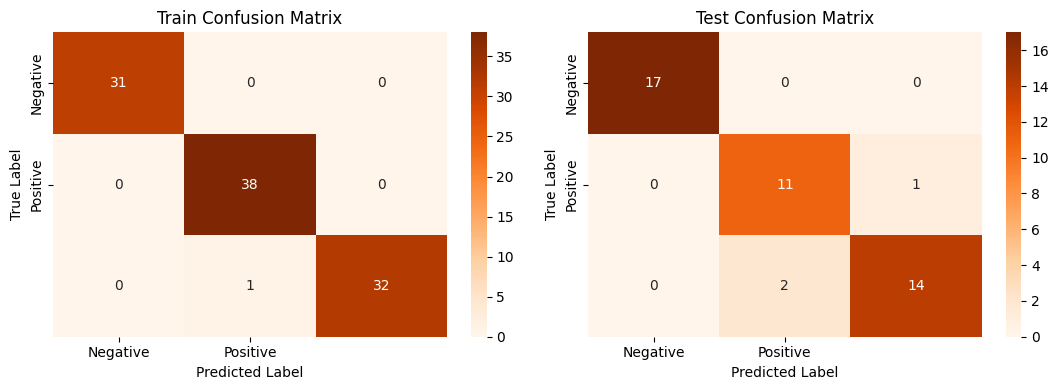


Train Classification Report:
|              |   precision |   recall |   f1-score |    support |
|:-------------|------------:|---------:|-----------:|-----------:|
| 0            |    1        | 1        |   1        |  31        |
| 1            |    0.974359 | 1        |   0.987013 |  38        |
| 2            |    1        | 0.969697 |   0.984615 |  33        |
| accuracy     |    0.990196 | 0.990196 |   0.990196 |   0.990196 |
| macro avg    |    0.991453 | 0.989899 |   0.990543 | 102        |
| weighted avg |    0.990447 | 0.990196 |   0.990184 | 102        |

Test Classification Report:
|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |    1        | 1        |   1        | 17        |
| 1            |    0.846154 | 0.916667 |   0.88     | 12        |
| 2            |    0.933333 | 0.875    |   0.903226 | 16        |
| accuracy     |    0.933333 | 0.933333 |   0.933333 |  0.9333

accuracy_test,▁
accuracy_train,▁
f1_test,▁
f1_train,▁
precision_test,▁
precision_train,▁
recall_test,▁
recall_train,▁
accuracy_test,0.93333
accuracy_train,0.9902
f1_test,0.93359


In [62]:
# Now we log the metrics for different models in Wandb to compare them easily
# ML Model - 1 Implementation
run = wandb.init(
    project="mlops_end_to_end_project",
    name="LogisticRegression"
)

lr_model = LogisticRegression(fit_intercept=True, max_iter=10000)
lr_score = evaluate_model(lr_model, x_train, x_test, y_train, y_test)

# Log metrics
wandb.log({
    "precision_train": lr_score[0],
    "precision_test": lr_score[1],
    "recall_train": lr_score[2],
    "recall_test": lr_score[3],
    "accuracy_train": lr_score[4],
    "accuracy_test": lr_score[5],
    "f1_train": lr_score[6],
    "f1_test": lr_score[7]
})

wandb.finish()

In [64]:
# Updated Evaluation metric Score Chart
score['Logistic regression'] = lr_score
score

,Logistic regression
Precision Train,0.990447
Precision Test,0.935271
Recall Train,0.990196
Recall Test,0.933333
Accuracy Train,0.990196
Accuracy Test,0.933333
F1 macro Train,0.990184
F1 macro Test,0.933591


In [76]:
# Saving the model
joblib.dump(lr_model, 'models/logistic_regression_model.pkl')

['models/logistic_regression_model.pkl']


Confusion Matrix:


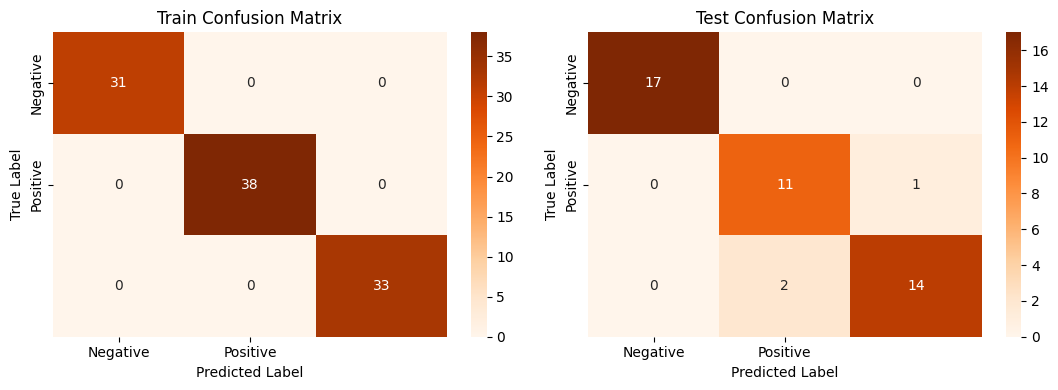


Train Classification Report:
|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |           1 |        1 |          1 |        31 |
| 1            |           1 |        1 |          1 |        38 |
| 2            |           1 |        1 |          1 |        33 |
| accuracy     |           1 |        1 |          1 |         1 |
| macro avg    |           1 |        1 |          1 |       102 |
| weighted avg |           1 |        1 |          1 |       102 |

Test Classification Report:
|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |    1        | 1        |   1        | 17        |
| 1            |    0.846154 | 0.916667 |   0.88     | 12        |
| 2            |    0.933333 | 0.875    |   0.903226 | 16        |
| accuracy     |    0.933333 | 0.933333 |   0.933333 |  0.933333 |
| m

accuracy_test,▁
accuracy_train,▁
f1_test,▁
f1_train,▁
precision_test,▁
precision_train,▁
recall_test,▁
recall_train,▁
accuracy_test,0.93333
accuracy_train,1
f1_test,0.93359


In [ ]:
# ML Model - 2 Implementation
run = wandb.init(
    project="mlops_end_to_end_project",
    name="DecisionTree"
)

dt_model = DecisionTreeClassifier(random_state=20)
dt_score = evaluate_model(dt_model, x_train, x_test, y_train, y_test)

# Log metrics
wandb.log({
    "precision_train": dt_score[0],
    "precision_test": dt_score[1],
    "recall_train": dt_score[2],
    "recall_test": dt_score[3],
    "accuracy_train": dt_score[4],
    "accuracy_test": dt_score[5],
    "f1_train": dt_score[6],
    "f1_test": dt_score[7]
})

wandb.finish()

In [65]:
# Updated Evaluation metric Score Chart
score['Decision Tree'] = dt_score
score

,Logistic regression,Decision Tree
Precision Train,0.990447,1.000000
Precision Test,0.935271,0.935271
Recall Train,0.990196,1.000000
Recall Test,0.933333,0.933333
Accuracy Train,0.990196,1.000000
Accuracy Test,0.933333,0.933333
F1 macro Train,0.990184,1.000000
F1 macro Test,0.933591,0.933591


In [77]:
# Saving the model
joblib.dump(dt_model, 'models/decision_tree_model.pkl')

['models/decision_tree_model.pkl']


Confusion Matrix:


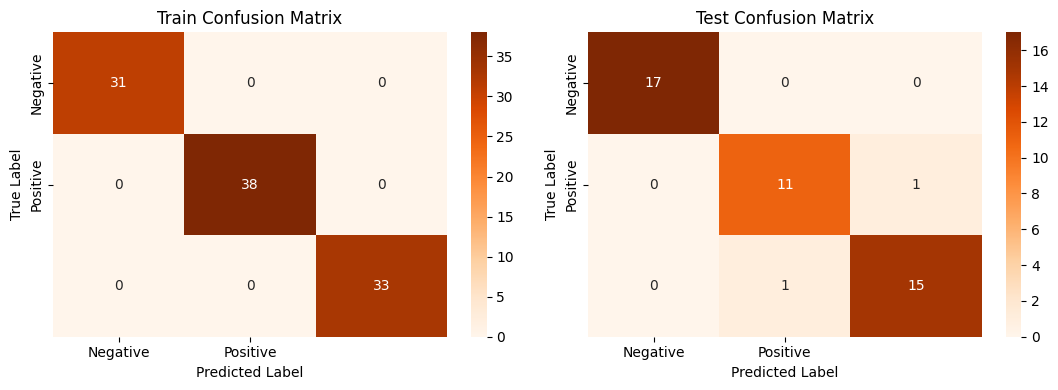


Train Classification Report:
|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |           1 |        1 |          1 |        31 |
| 1            |           1 |        1 |          1 |        38 |
| 2            |           1 |        1 |          1 |        33 |
| accuracy     |           1 |        1 |          1 |         1 |
| macro avg    |           1 |        1 |          1 |       102 |
| weighted avg |           1 |        1 |          1 |       102 |

Test Classification Report:
|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |    1        | 1        |   1        | 17        |
| 1            |    0.916667 | 0.916667 |   0.916667 | 12        |
| 2            |    0.9375   | 0.9375   |   0.9375   | 16        |
| accuracy     |    0.955556 | 0.955556 |   0.955556 |  0.955556 |
| m

accuracy_test,▁
accuracy_train,▁
f1_test,▁
f1_train,▁
precision_test,▁
precision_train,▁
recall_test,▁
recall_train,▁
accuracy_test,0.95556
accuracy_train,1
f1_test,0.95556


In [66]:
# ML Model - 3 Implementation
run = wandb.init(
    project = "mlops_end_to_end_project",
    name = "Random Forest"
)

rf_model = RandomForestClassifier(random_state=0)
rf_score = evaluate_model(rf_model, x_train, x_test, y_train, y_test)

# Log metrics
wandb.log({
    "precision_train": rf_score[0],
    "precision_test": rf_score[1],
    "recall_train": rf_score[2],
    "recall_test": rf_score[3],
    "accuracy_train": rf_score[4],
    "accuracy_test": rf_score[5],
    "f1_train": rf_score[6],
    "f1_test": rf_score[7]
})

wandb.finish()

In [67]:
# Updated Evaluation metric Score Chart
score['Random Forest'] = rf_score
score

,Logistic regression,Decision Tree,Random Forest
Precision Train,0.990447,1.000000,1.000000
Precision Test,0.935271,0.935271,0.955556
Recall Train,0.990196,1.000000,1.000000
Recall Test,0.933333,0.933333,0.955556
Accuracy Train,0.990196,1.000000,1.000000
Accuracy Test,0.933333,0.933333,0.955556
F1 macro Train,0.990184,1.000000,1.000000
F1 macro Test,0.933591,0.933591,0.955556


In [78]:
# Saving the model
joblib.dump(rf_model, 'models/random_forest_model.pkl')

['models/random_forest_model.pkl']


Confusion Matrix:


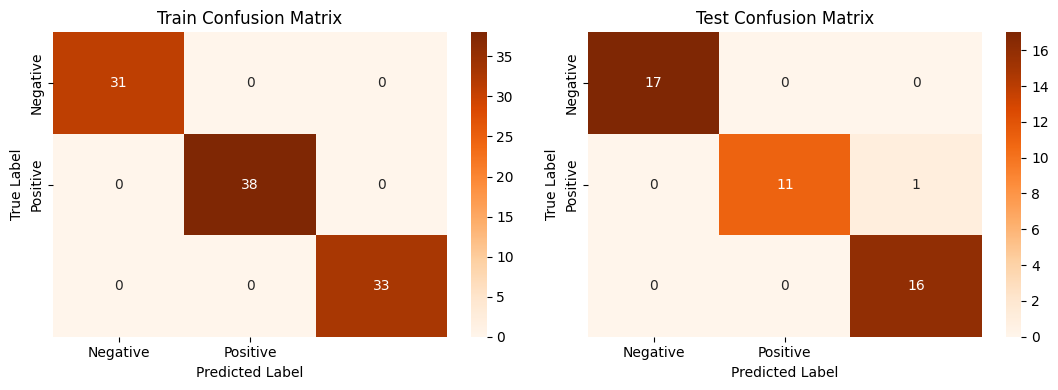


Train Classification Report:
|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |           1 |        1 |          1 |        31 |
| 1            |           1 |        1 |          1 |        38 |
| 2            |           1 |        1 |          1 |        33 |
| accuracy     |           1 |        1 |          1 |         1 |
| macro avg    |           1 |        1 |          1 |       102 |
| weighted avg |           1 |        1 |          1 |       102 |

Test Classification Report:
|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |    1        | 1        |   1        | 17        |
| 1            |    1        | 0.916667 |   0.956522 | 12        |
| 2            |    0.941176 | 1        |   0.969697 | 16        |
| accuracy     |    0.977778 | 0.977778 |   0.977778 |  0.977778 |
| m

accuracy_test,▁
accuracy_train,▁
f1_test,▁
f1_train,▁
precision_test,▁
precision_train,▁
recall_test,▁
recall_train,▁
accuracy_test,0.97778
accuracy_train,1
f1_test,0.97763


In [68]:
# ML Model - 4 Implementation
run = wandb.init(
    project = "mlops_end_to_end_project",
    name = "Support Vector Machine"
)

svm_model = SVC(kernel='linear', random_state=0, probability=True)
svm_score = evaluate_model(svm_model, x_train, x_test, y_train, y_test)

# Log metrics
wandb.log({
    "precision_train": svm_score[0],
    "precision_test": svm_score[1],
    "recall_train": svm_score[2],
    "recall_test": svm_score[3],
    "accuracy_train": svm_score[4],
    "accuracy_test": svm_score[5],
    "f1_train": svm_score[6],
    "f1_test": svm_score[7]
})

wandb.finish()

In [69]:
# Updated Evaluation metric Score Chart
score['SVM'] = svm_score
score

,Logistic regression,Decision Tree,Random Forest,SVM
Precision Train,0.990447,1.000000,1.000000,1.000000
Precision Test,0.935271,0.935271,0.955556,0.979085
Recall Train,0.990196,1.000000,1.000000,1.000000
Recall Test,0.933333,0.933333,0.955556,0.977778
Accuracy Train,0.990196,1.000000,1.000000,1.000000
Accuracy Test,0.933333,0.933333,0.955556,0.977778
F1 macro Train,0.990184,1.000000,1.000000,1.000000
F1 macro Test,0.933591,0.933591,0.955556,0.977631


In [79]:
# Saving the Model
joblib.dump(svm_model, 'models/support_vector_machine_model.pkl')

['models/support_vector_machine_model.pkl']


Confusion Matrix:


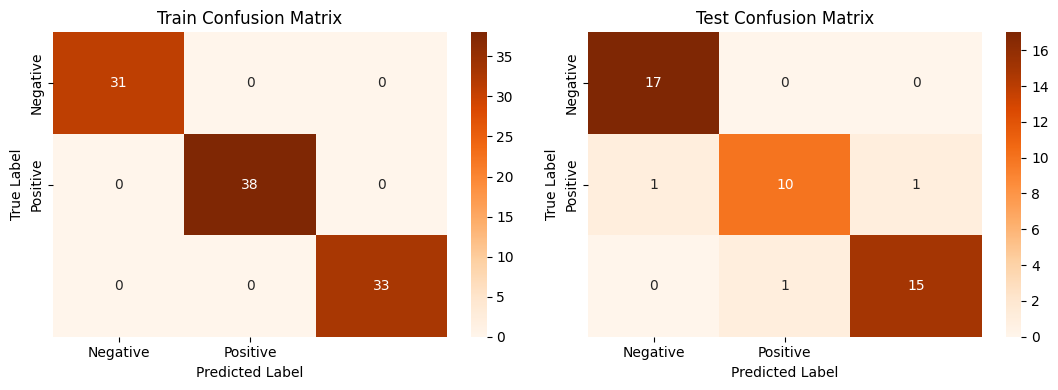


Train Classification Report:
|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |           1 |        1 |          1 |        31 |
| 1            |           1 |        1 |          1 |        38 |
| 2            |           1 |        1 |          1 |        33 |
| accuracy     |           1 |        1 |          1 |         1 |
| macro avg    |           1 |        1 |          1 |       102 |
| weighted avg |           1 |        1 |          1 |       102 |

Test Classification Report:
|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |    0.944444 | 1        |   0.971429 | 17        |
| 1            |    0.909091 | 0.833333 |   0.869565 | 12        |
| 2            |    0.9375   | 0.9375   |   0.9375   | 16        |
| accuracy     |    0.933333 | 0.933333 |   0.933333 |  0.933333 |
| m

accuracy_test,▁
accuracy_train,▁
f1_test,▁
f1_train,▁
precision_test,▁
precision_train,▁
recall_test,▁
recall_train,▁
accuracy_test,0.93333
accuracy_train,1
f1_test,0.9322


In [70]:
# ML Model - 5 Implementation
run = wandb.init(
    project = "mlops_end_to_end_project",
    name = "XGBoost"
)

xgb_model = xgb.XGBClassifier()
xgb_score = evaluate_model(xgb_model, x_train, x_test, y_train, y_test)

# Log metrics
wandb.log({
    "precision_train": xgb_score[0],
    "precision_test": xgb_score[1],
    "recall_train": xgb_score[2],
    "recall_test": xgb_score[3],
    "accuracy_train": xgb_score[4],
    "accuracy_test": xgb_score[5],
    "f1_train": xgb_score[6],
    "f1_test": xgb_score[7]
})

wandb.finish()

In [71]:
# Updated Evaluation metric Score Chart
score['XGB'] = xgb_score
score

,Logistic regression,Decision Tree,Random Forest,SVM,XGB
Precision Train,0.990447,1.000000,1.000000,1.000000,1.000000
Precision Test,0.935271,0.935271,0.955556,0.979085,0.932548
Recall Train,0.990196,1.000000,1.000000,1.000000,1.000000
Recall Test,0.933333,0.933333,0.955556,0.977778,0.933333
Accuracy Train,0.990196,1.000000,1.000000,1.000000,1.000000
Accuracy Test,0.933333,0.933333,0.955556,0.977778,0.933333
F1 macro Train,0.990184,1.000000,1.000000,1.000000,1.000000
F1 macro Test,0.933591,0.933591,0.955556,0.977631,0.932202


In [80]:
# saving the model
joblib.dump(xgb_model, 'models/xgboost_model.pkl')

['models/xgboost_model.pkl']